### Configuración

Primero se cargan las librerías necesarias para el desarrollo del _notebook_

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from yaml import safe_load

Ahora se definen rutas relativas al _notebook_, para una adecuada manipulación de archivos dentro del directorio raíz.

In [2]:
# Ruta a directorio raíz
ROOT = os.path.dirname(os.getcwd())

# Abrir archivo de configuración
with open(file=os.path.join(ROOT, 'config.yml'), mode='r') as _file:
    CONFIG = safe_load(_file)
_file.close()

# 1. Regla de actualización

Revisar el **ejemplo 5.3.** del libro _Doing Bayesian Data Analyis_, J. Kruschke, 2° Edición.

## 1.1. Un primer ejemplo

Este _notebook_ es un ejemplo práctico de la regla de actualización utilizada en análisis de datos Bayesiano, usando como ejemplo lanzamientos de una moneda, es decir, el modelo de datos que describe el problema es una distribución Bernoulli.

$$p(y|\theta) = \theta^y (1 - \theta)^{1-y}$$

Para ilustrarlo, considera que existe una fábrica de monedas cuyo proceso de manufactura resulta en monedas cargadas a una cara con parámetro $\theta\in[0.0,0.1,...,0.9,1.0]$. Supón que nuestro conocimiento inicial del problema sugiere que la fábrica tiende a producir monedas justas ($\theta=0.5$), y que cualquier otra moneda tiene menor probabilidad de ser producida.

El conocimiento inicial se puede representar con la siguiente distribución triangular:

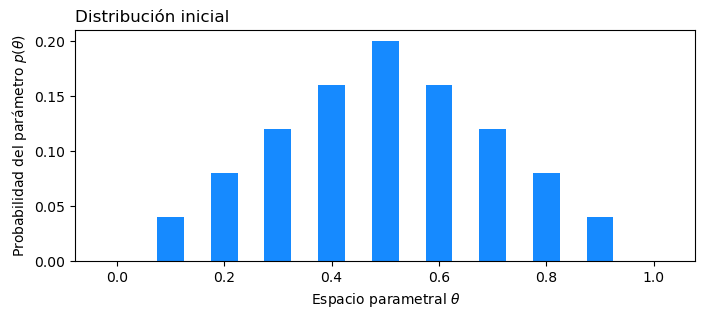

In [3]:
n_params = 11

params = (
    # Iniciar objeto dataframe
    pd.DataFrame(
        # Datos iniciales
        data = {
            # Parámetro de la moneda
            'theta': np.linspace(start=0, stop=1, num=n_params)})
    # Columnas calculadas de la tabla
    .assign(
        # Distribución triangular de probabilidad para parámetro theta
        _p_theta = lambda table: np.minimum(table.theta, 1 - table.theta)
        # Condición de suma 1 para p_theta
        ,p_theta = lambda table: table._p_theta / table._p_theta.sum())
)

# Eliminar columnas temporales
params.drop(
    columns = [col for col in params.columns if col.startswith('_')]
    ,inplace=True)

# Configuración de figura
fig, ax = plt.subplots(figsize=(8,3))

# Elementos de visualización
ax.bar(
    x = params.theta
    ,height = params.p_theta
    ,width = 0.05
    ,color = CONFIG['graficas']['colors']['azul'])

# Anotaciones de figura
ax.set_title(f'Distribución inicial', loc='left')
ax.set_xlabel(r'Espacio parametral $\theta$')
ax.set_ylabel(r'Probabilidad del parámetro $p(\theta)$')

plt.show()

Definimos una función para evaluar la verosimilitud $p(y|\theta)$ dado un valor de $y$:

In [4]:
def bernoulli_pdf(y):
    return lambda theta: theta**y * (1 - theta)**(1-y)

El siguiente paso sería obtener datos ($D$) para determinar la verosimilitud de que estos hayan sido generados por cada $\theta^*$ del espacio parametral.

Supón que hacemos un lanzamiento de moneda y el resultado es $y=1$. Dado que se trata únicamente de un lanzamiento, entonces la verosimilitud de $y=1$ bajo los diferentes valores del parámetro $\theta$ quedaría dada por:

$$p(y|\theta)_{y=1} = \theta$$

Con lo cual se puede obtener la probabilidad de obtener $y=1$ en un lanzamiento bajos los diferentes valores de $\theta$, resultando en la siguiente distribución de verosimilitud:

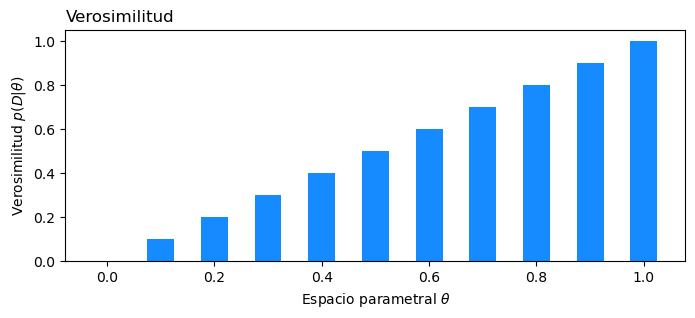

In [5]:
# Valor observado del lanzamiento
y = 1

# Verosimilitud de la observación bajo distintos valores del parámetro
params['verosim'] = np.apply_along_axis(
    func1d = bernoulli_pdf(y=1)
    ,axis = 0
    ,arr = params.theta)

# Configuración de figura
fig, ax = plt.subplots(figsize=(8,3))

# Elementos de visualización
ax.bar(
    x = params.theta
    ,height = params.verosim
    ,width = 0.05
    ,color = CONFIG['graficas']['colors']['azul'])

# Anotaciones de figura
ax.set_title(f'Verosimilitud', loc='left')
ax.set_xlabel(r'Espacio parametral $\theta$')
ax.set_ylabel(r'Verosimilitud $p(D|\theta)$')

plt.show()

Una vez obtenida la verosimilitud, entonces se reubica mi credibilidad sobre los diferentes parámetros utilizando la regla de Bayes como regla de actualización. Para ello, es necesario calcular la _evidencia_ $p(D)$:

$$p(D) = \sum_{\theta^*}p(D|\theta^*)p(\theta^*)$$

En donde cada uno de los elementos $p(D|\theta^*)p(\theta^*)$ son las probabilidades marginales de cada uno de los parámetros $\theta^*$, y la _evidencia_ es la suma de todas las marginales. La distribución posterior sería entonces:

$$p(\theta|D) = \frac{p(D|\theta)p(\theta)}{p(D)}$$

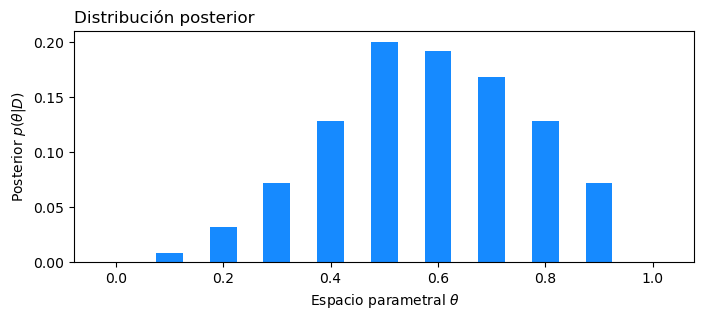

In [6]:
params = (
    params
    .assign(
        # Calcular probabilidades marginales
        marginal = lambda table: table.verosim * table.p_theta
        # Actualizar estado de conocimiento con regla de bayes
        ,theta_post = lambda table: table.marginal / table.marginal.sum()))

# Configuración de figura
fig, ax = plt.subplots(figsize=(8,3))

# Elementos de visualización
ax.bar(
    x = params.theta
    ,height = params.theta_post
    ,width = 0.05
    ,color = CONFIG['graficas']['colors']['azul'])

# Anotaciones de figura
ax.set_title(f'Distribución posterior', loc='left')
ax.set_xlabel(r'Espacio parametral $\theta$')
ax.set_ylabel(r'Posterior $p(\theta|D)$')

plt.show()

## 1.2. Un poco más complejo

Ahora supón que la fábrica tiene capacidad de fabricar un rango mucho más amplio de monedas, en lugar de clasificar sus monedas en 11 categorías son 1,001. El problema sigue siendo el mismo y la regla de Bayes aplica exactamente igual, pero ahora se exploran mucho más alternativas para la moneda.

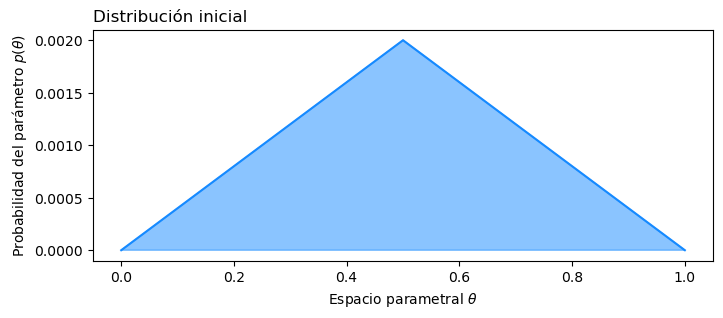

In [7]:
n_params = 1001

params = (
    # Iniciar objeto dataframe
    pd.DataFrame(
        # Datos iniciales
        data = {
            # Parámetro de la moneda
            'theta': np.linspace(start=0, stop=1, num=n_params)})
    # Columnas calculadas de la tabla
    .assign(
        # Distribución triangular de probabilidad para parámetro theta
        _p_theta = lambda table: np.minimum(table.theta, 1 - table.theta)
        # Condición de suma 1 para p_theta
        ,p_theta = lambda table: table._p_theta / table._p_theta.sum())
)

# Eliminar columnas temporales
params.drop(
    columns = [col for col in params.columns if col.startswith('_')]
    ,inplace=True)

# Configuración de figura
fig, ax = plt.subplots(figsize=(8,3))

# Elementos de visualización
x = params.theta
y = params.p_theta
ax.plot(x, y, color=CONFIG['graficas']['colors']['azul'])
ax.fill(x, y, color=CONFIG['graficas']['colors']['azul'], alpha=0.5)

# Anotaciones de figura
ax.set_title(f'Distribución inicial', loc='left')
ax.set_xlabel(r'Espacio parametral $\theta$')
ax.set_ylabel(r'Probabilidad del parámetro $p(\theta)$')

plt.show()

La primera diferencia visible es que la escala de probabilidad es significativamente más pequeña, y es que el parámetro $\theta$ al poder tomar muchos más valores reduce la masa que se concentra en cada uno de ellos.

Nuevamente, el siguiente paso es obtener datos ($D$) para actualizar mi estado de conocimiento, pero en esta ocasión se realizará con más de un dato. Supón que se realizan $n$ experimentos de los cuales el 25% resultaron en $y=1$, por ejemplo, 1 de 4 lanzamientos resultaron en $y=1$.

Tomando esto en cuenta, se calcula la verosimilitud de que cada parámetro $\theta^*$ haya generado los datos. En este caso, como se trata de más de 1 lanzamiento y supongo que cada uno es independiente del otro, entonces el cálculo de la verosimilitud se vuelve una productoria de todos los lanzamientos

$$p(y_i|\theta) = \prod_i \theta^{y_i}(1-\theta)^{1-y_i}$$

Primero se genera un conjunto de 4 lanzamiento en el que el 25% de los datos sean $y=1$

In [8]:
# Número de lanzamientos y proporción de y=1
n = 4
prop = 0.25

# Conjunto de observaciones
nuevos_params = np.concatenate([
    np.zeros(shape=(n - int(n * prop), ))
    ,np.ones(shape=(int(n * prop), )) ], axis=0)
nuevos_params

array([0., 0., 0., 1.])

Ahora se calcula la verosimilitud, con la diferencia de que la salida ahora será un arreglo de $p$ por $q$ siendo:

* $p$: Número de parámetros
* $q$: Número de datos nuevos

Y la verosimilitud para cada parámetro será el producto de las columnas del arreglo

In [9]:
verosim_arr = np.apply_along_axis(
    func1d = bernoulli_pdf(y=nuevos_params)
    ,axis = 1
    ,arr = np.array(params.theta).reshape((-1, 1)))

print(verosim_arr.shape)
verosim_arr

(1001, 4)


array([[1.   , 1.   , 1.   , 0.   ],
       [0.999, 0.999, 0.999, 0.001],
       [0.998, 0.998, 0.998, 0.002],
       ...,
       [0.002, 0.002, 0.002, 0.998],
       [0.001, 0.001, 0.001, 0.999],
       [0.   , 0.   , 0.   , 1.   ]])

Al obtener la verosimilitud, se puede visualizar su comportamiento

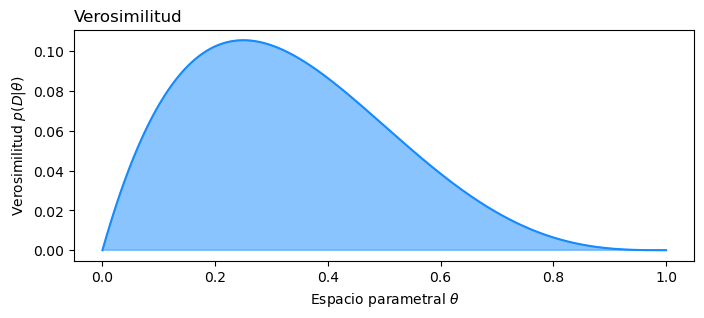

In [10]:
# Verosimilitud de la observación bajo distintos valores del parámetro
params['verosim'] = verosim_arr.prod(axis=1)

# Configuración de figura
fig, ax = plt.subplots(figsize=(8,3))

# Elementos de visualización
x = params.theta
y = params.verosim
ax.plot(x, y, color=CONFIG['graficas']['colors']['azul'])
ax.fill(x, y, color=CONFIG['graficas']['colors']['azul'], alpha=0.5)

# Anotaciones de figura
ax.set_title(f'Verosimilitud', loc='left')
ax.set_xlabel(r'Espacio parametral $\theta$')
ax.set_ylabel(r'Verosimilitud $p(D|\theta)$')

plt.show()

Una vez obtenida la verosimilitud, la actualización de mi estado de conocimiento utilizando la regla de Bayes es exactamente igual que en el caso anterior:

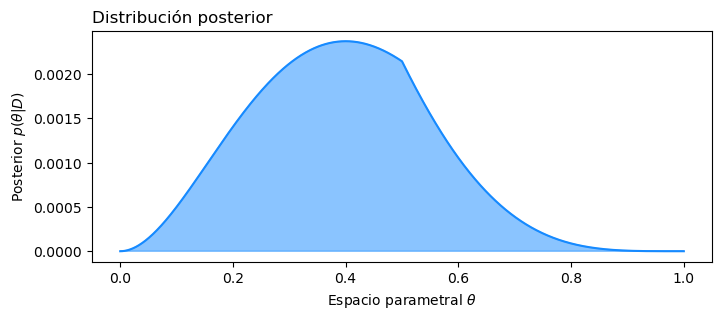

In [11]:
datos = (
    params
    .assign(
        # Calcular probabilidades marginales
        marginal = lambda table: table.verosim * table.p_theta
        # Actualizar estado de conocimiento con regla de bayes
        ,theta_post = lambda table: table.marginal / table.marginal.sum()))

# Configuración de figura
fig, ax = plt.subplots(figsize=(8,3))

# Elementos de visualización
x = datos.theta
y = datos.theta_post
ax.plot(x, y, color=CONFIG['graficas']['colors']['azul'])
ax.fill(x, y, color=CONFIG['graficas']['colors']['azul'], alpha=0.5)

# Anotaciones de figura
ax.set_title(f'Distribución posterior', loc='left')
ax.set_xlabel(r'Espacio parametral $\theta$')
ax.set_ylabel(r'Posterior $p(\theta|D)$')

plt.show()

Se puede establecer como una regla que la distribución posterior es un balance entre la distribución inicial y la verosimilitud, y esta se puede _cargar_ tanto a un lado como a otro dependiendo de ciertas condiciones. En general:

* Si los datos son pequeños y la inicial es muy informativa (baja varianza), la posterior se asemejará más a la inicial
* Si los datos son grandes y la inicial es poco informativa (alta varianza), la posterior se asemejará más a la verosimilitud

---